In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [139]:
data = pd.read_csv('train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)
data.head(10)

,Id,County,Province_State,Country_Region,Population,Weight,Target,TargetValue
Date,,,,,,,,
2020-01-23,1,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases,0
2020-01-23,2,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities,0
2020-01-24,3,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases,0
2020-01-24,4,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities,0
2020-01-25,5,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases,0
2020-01-25,6,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities,0
2020-01-26,7,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases,0
2020-01-26,8,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities,0
2020-01-27,9,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases,0


In [138]:
evaluate_data = pd.read_csv('test.csv')
evaluate_data['Date'] = pd.to_datetime(evaluate_data['Date'])
evaluate_data.set_index('Date',inplace=True)
evaluate_data.head(10)

,ForecastId,County,Province_State,Country_Region,Population,Weight,Target
Date,,,,,,,
2020-04-27,1,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases
2020-04-27,2,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities
2020-04-28,3,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases
2020-04-28,4,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities
2020-04-29,5,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases
2020-04-29,6,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities
2020-04-30,7,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases
2020-04-30,8,NaN,NaN,Afghanistan,27657145,0.583587,Fatalities
2020-05-01,9,NaN,NaN,Afghanistan,27657145,0.058359,ConfirmedCases


In [7]:
submission = pd.read_csv('submission.csv')
submission.head(10)

,ForecastId_Quantile,TargetValue
0,1_0.05,1
1,1_0.5,1
2,1_0.95,1
3,2_0.05,1
4,2_0.5,1
5,2_0.95,1
6,3_0.05,1
7,3_0.5,1
8,3_0.95,1
9,4_0.05,1


In [140]:
cases_data = data[data['Target'] == 'ConfirmedCases']
fatal_data = data[data['Target'] == 'Fatalities']

def find_top_n(df, column, topn):
    total = df.groupby([column])['TargetValue'].sum()
    top_n = total.sort_values(ascending = False)[:topn]
    top_n_countries = []
    for i in top_n.index:
        top_n_countries.append(i)
    return top_n_countries

cases_top_10 = find_top_n(cases_data,'Country_Region',10)
death_top_10 = find_top_n(fatal_data,'Country_Region',10)

In [143]:
print('Basic information from the data:')
print('----------------------------------------------')
print('1. Time')
print('Time range on training data:', data.index.min(),' - ',data.index.max())
print('Total days on training data:', data.index.nunique())
print('Time range on test data:', evaluate_data.index.min(),' - ',evaluate_data.index.max())
print('Total days on test data:', evaluate_data.index.nunique())
print('2. Countries')
print('The number of countries recorded:', data['Country_Region'].nunique())
print('Top 10 coutries that have most cases: ',cases_top_10)
print('Top 10 coutries that have most deaths: ',death_top_10)

Basic information from the data:
----------------------------------------------
1. Time
Time range on training data: 2020-01-23 00:00:00  -  2020-06-10 00:00:00
Total days on training data: 140
Time range on test data: 2020-04-27 00:00:00  -  2020-06-10 00:00:00
Total days on test data: 45
2. Countries
The number of countries recorded: 187
Top 10 coutries that have most cases:  ['US', 'Brazil', 'Russia', 'United Kingdom', 'India', 'Spain', 'Italy', 'Peru', 'Canada', 'France']
Top 10 coutries that have most deaths:  ['US', 'United Kingdom', 'Brazil', 'Italy', 'France', 'Spain', 'Canada', 'Mexico', 'Belgium', 'China']


---------
## Visualization on Hotspot Countries

--------

### 1. The numebr of cases and deaths in each country over time

In [158]:
# let's see which country are not in case top10 but in death top10
t_countries = []
for i in death_top_10:
    if i not in cases_top_10:
        t_countries.append(i)
    else:
        pass
# We will add them in as hotspot countries
hotspots = cases_top_10+t_countries

In [160]:
cases_by_country = cases_data[['Country_Region','TargetValue']].reset_index()
cases_by_country = cases_by_country.groupby(['Date','Country_Region'])['TargetValue'].sum().unstack()
cases_df = cases_by_country[hotspots]

deaths_by_country = fatal_data[['Country_Region','TargetValue']].reset_index()
deaths_by_country = deaths_by_country.groupby(['Date','Country_Region'])['TargetValue'].sum().unstack()
deaths_df = deaths_by_country[hotspots]

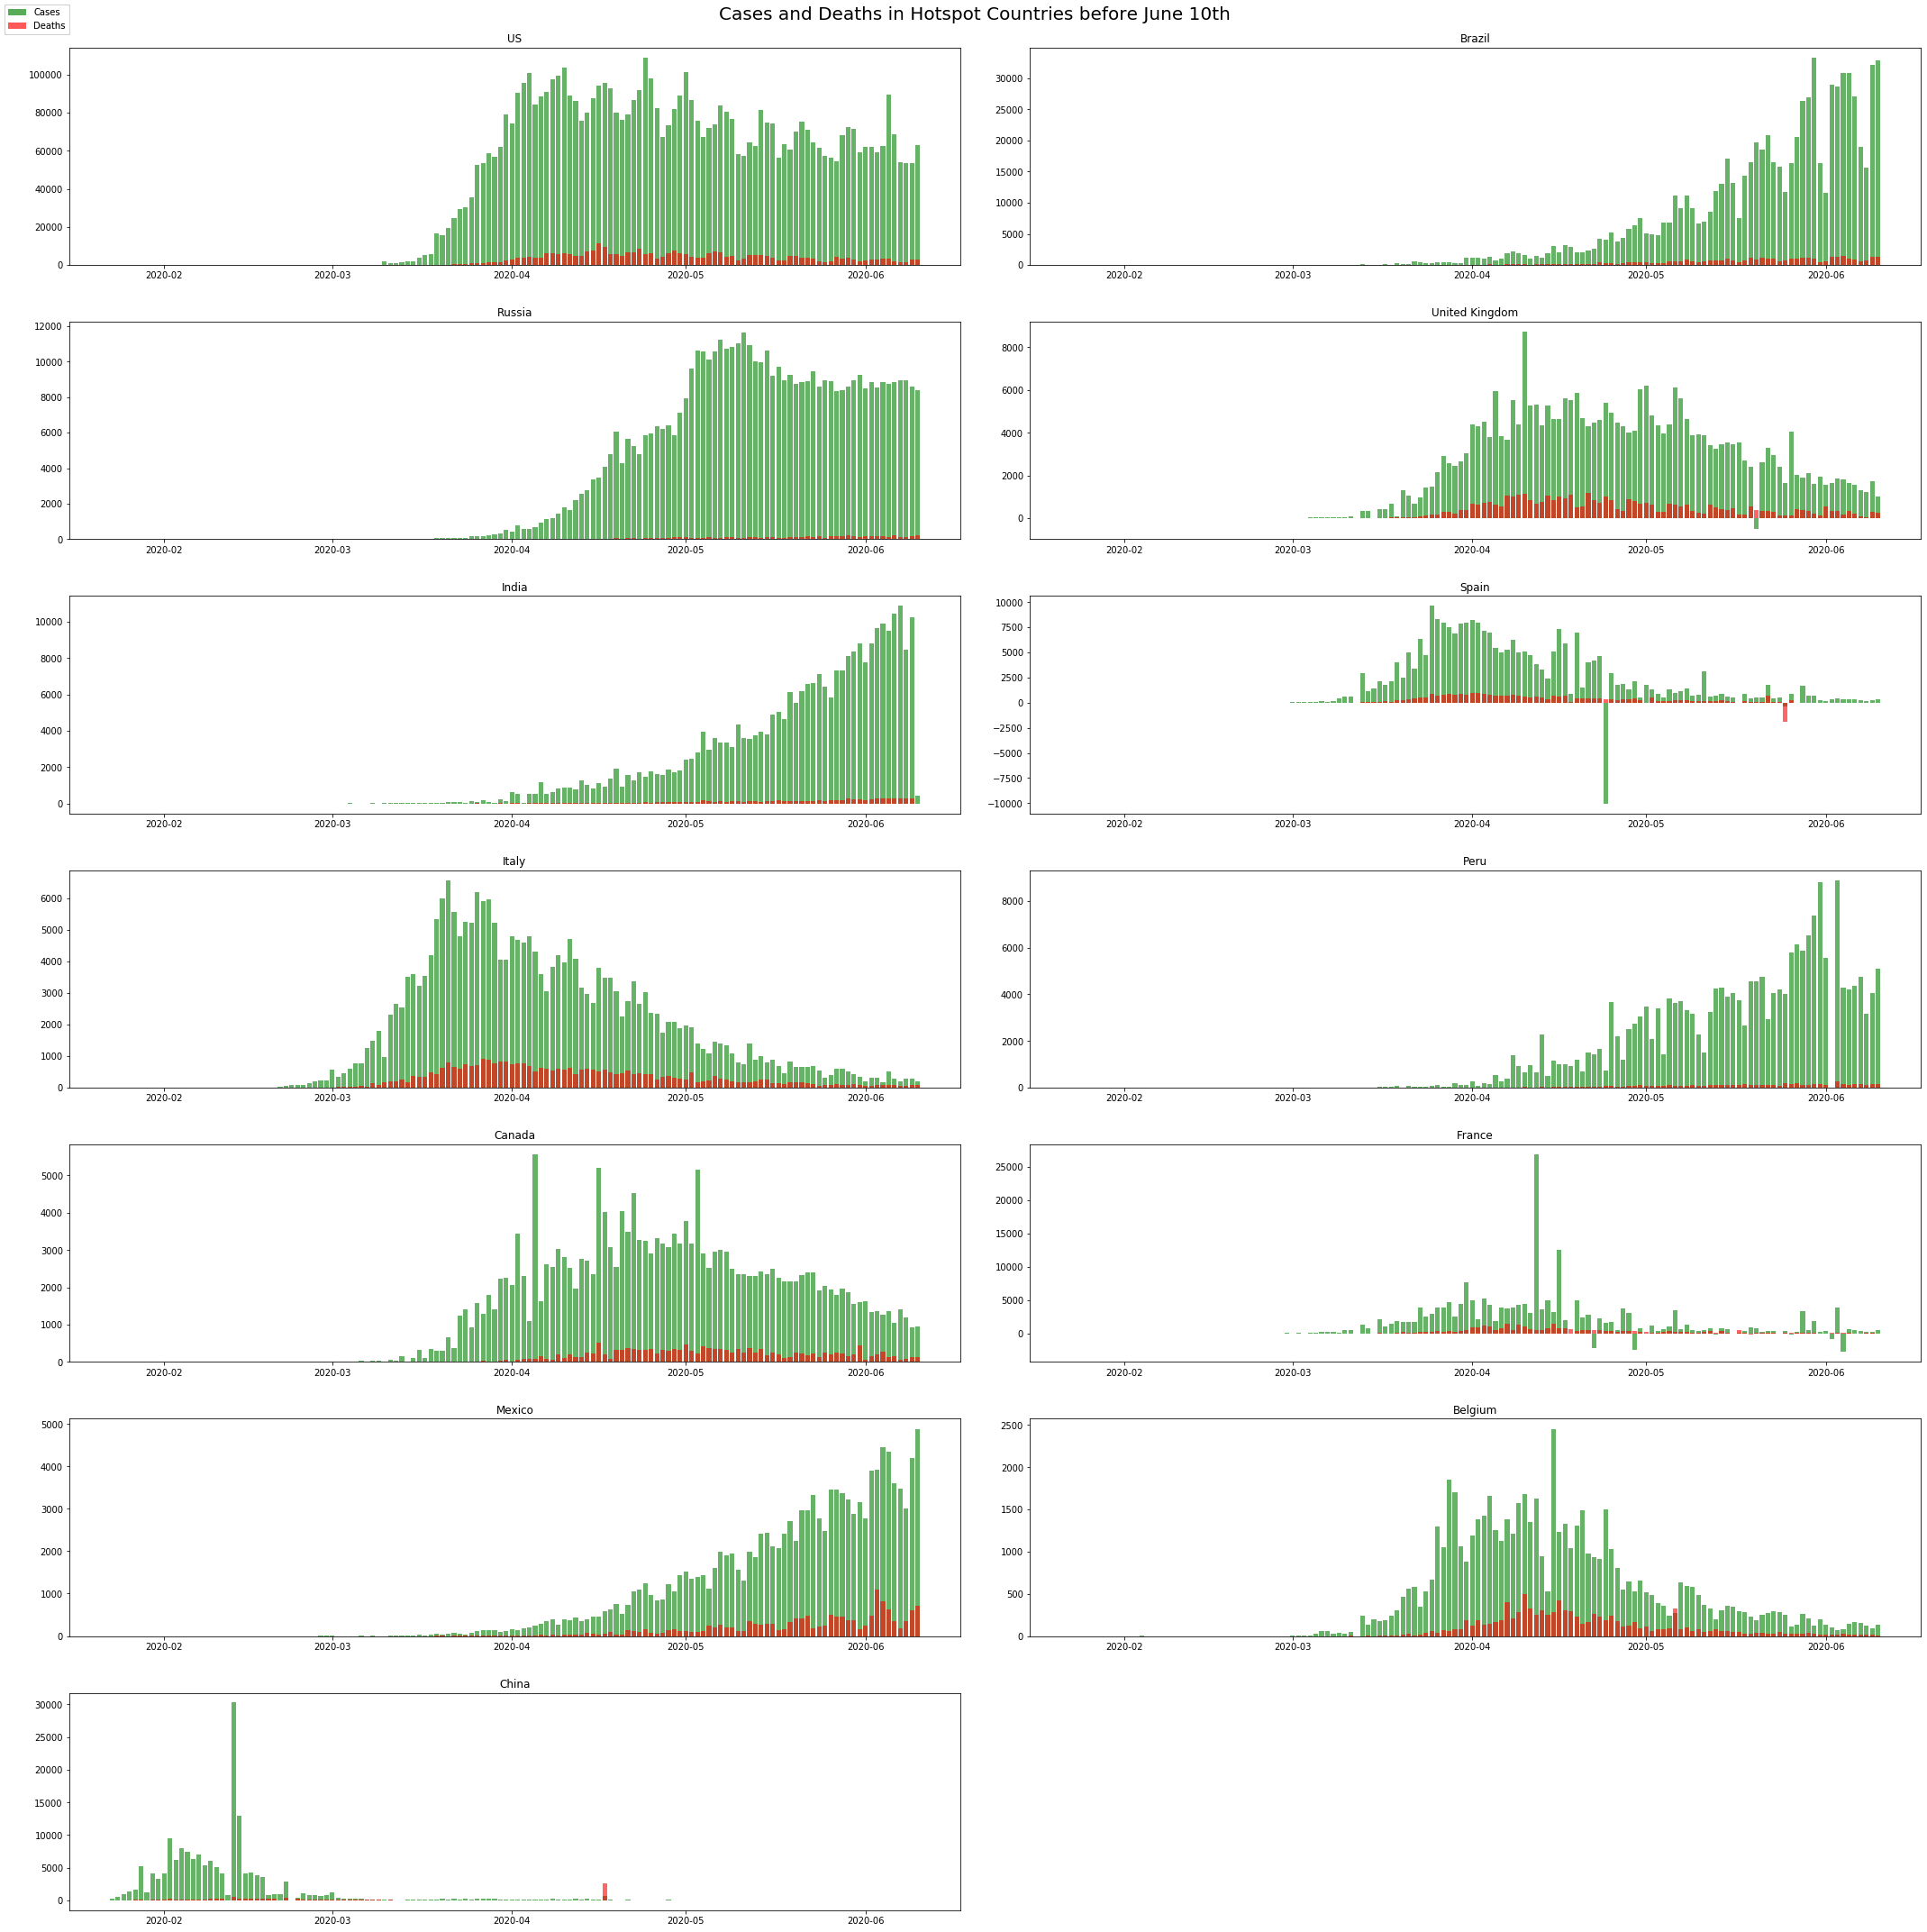

In [178]:
fig = plt.figure(figsize= (30,30))
plt.suptitle('Cases and Deaths in Hotspot Countries before June 10th',fontsize = 20,y=1.0)
for i in range(13):
    ax = fig.add_subplot(7,2,i+1)
    ax.bar(cases_df.index,cases_df.iloc[:,i],color = 'green',alpha = 0.6, label = 'Cases');
    ax.bar(deaths_df.index,deaths_df.iloc[:,i],color = 'red',alpha = 0.6, label = 'Deaths');
    plt.title(hotspots[i])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
plt.tight_layout(pad=3.0)

In [177]:
# What did the negative values mean?
print('There are {} records that are negative cases'.format(cases_data[(cases_data['TargetValue'] <0)].count()['TargetValue']))
print('There are {} records that are negative deaths'.format(fatal_data[(fatal_data['TargetValue'] <0)].count()['TargetValue']))

There are 3859 records that are negative cases
There are 728 records that are negative deaths


### 2. The percentage of cases in each country over time
<br>

We know that the severety of covid spead is associate with the percentage value over the total population, so we will also visualize the proportion of cases over the total population for each country.

In [187]:
pct_by_country = cases_data[['Country_Region','Population','TargetValue']].reset_index()
cases_calculate = pct_by_country.groupby(['Date','Country_Region'])['TargetValue'].sum().unstack()
population_calculate = pct_by_country.groupby(['Date','Country_Region'])['Population'].max().unstack()
pct_by_country = (cases_calculate/population_calculate)*100
pct_df = pct_by_country[hotspots]

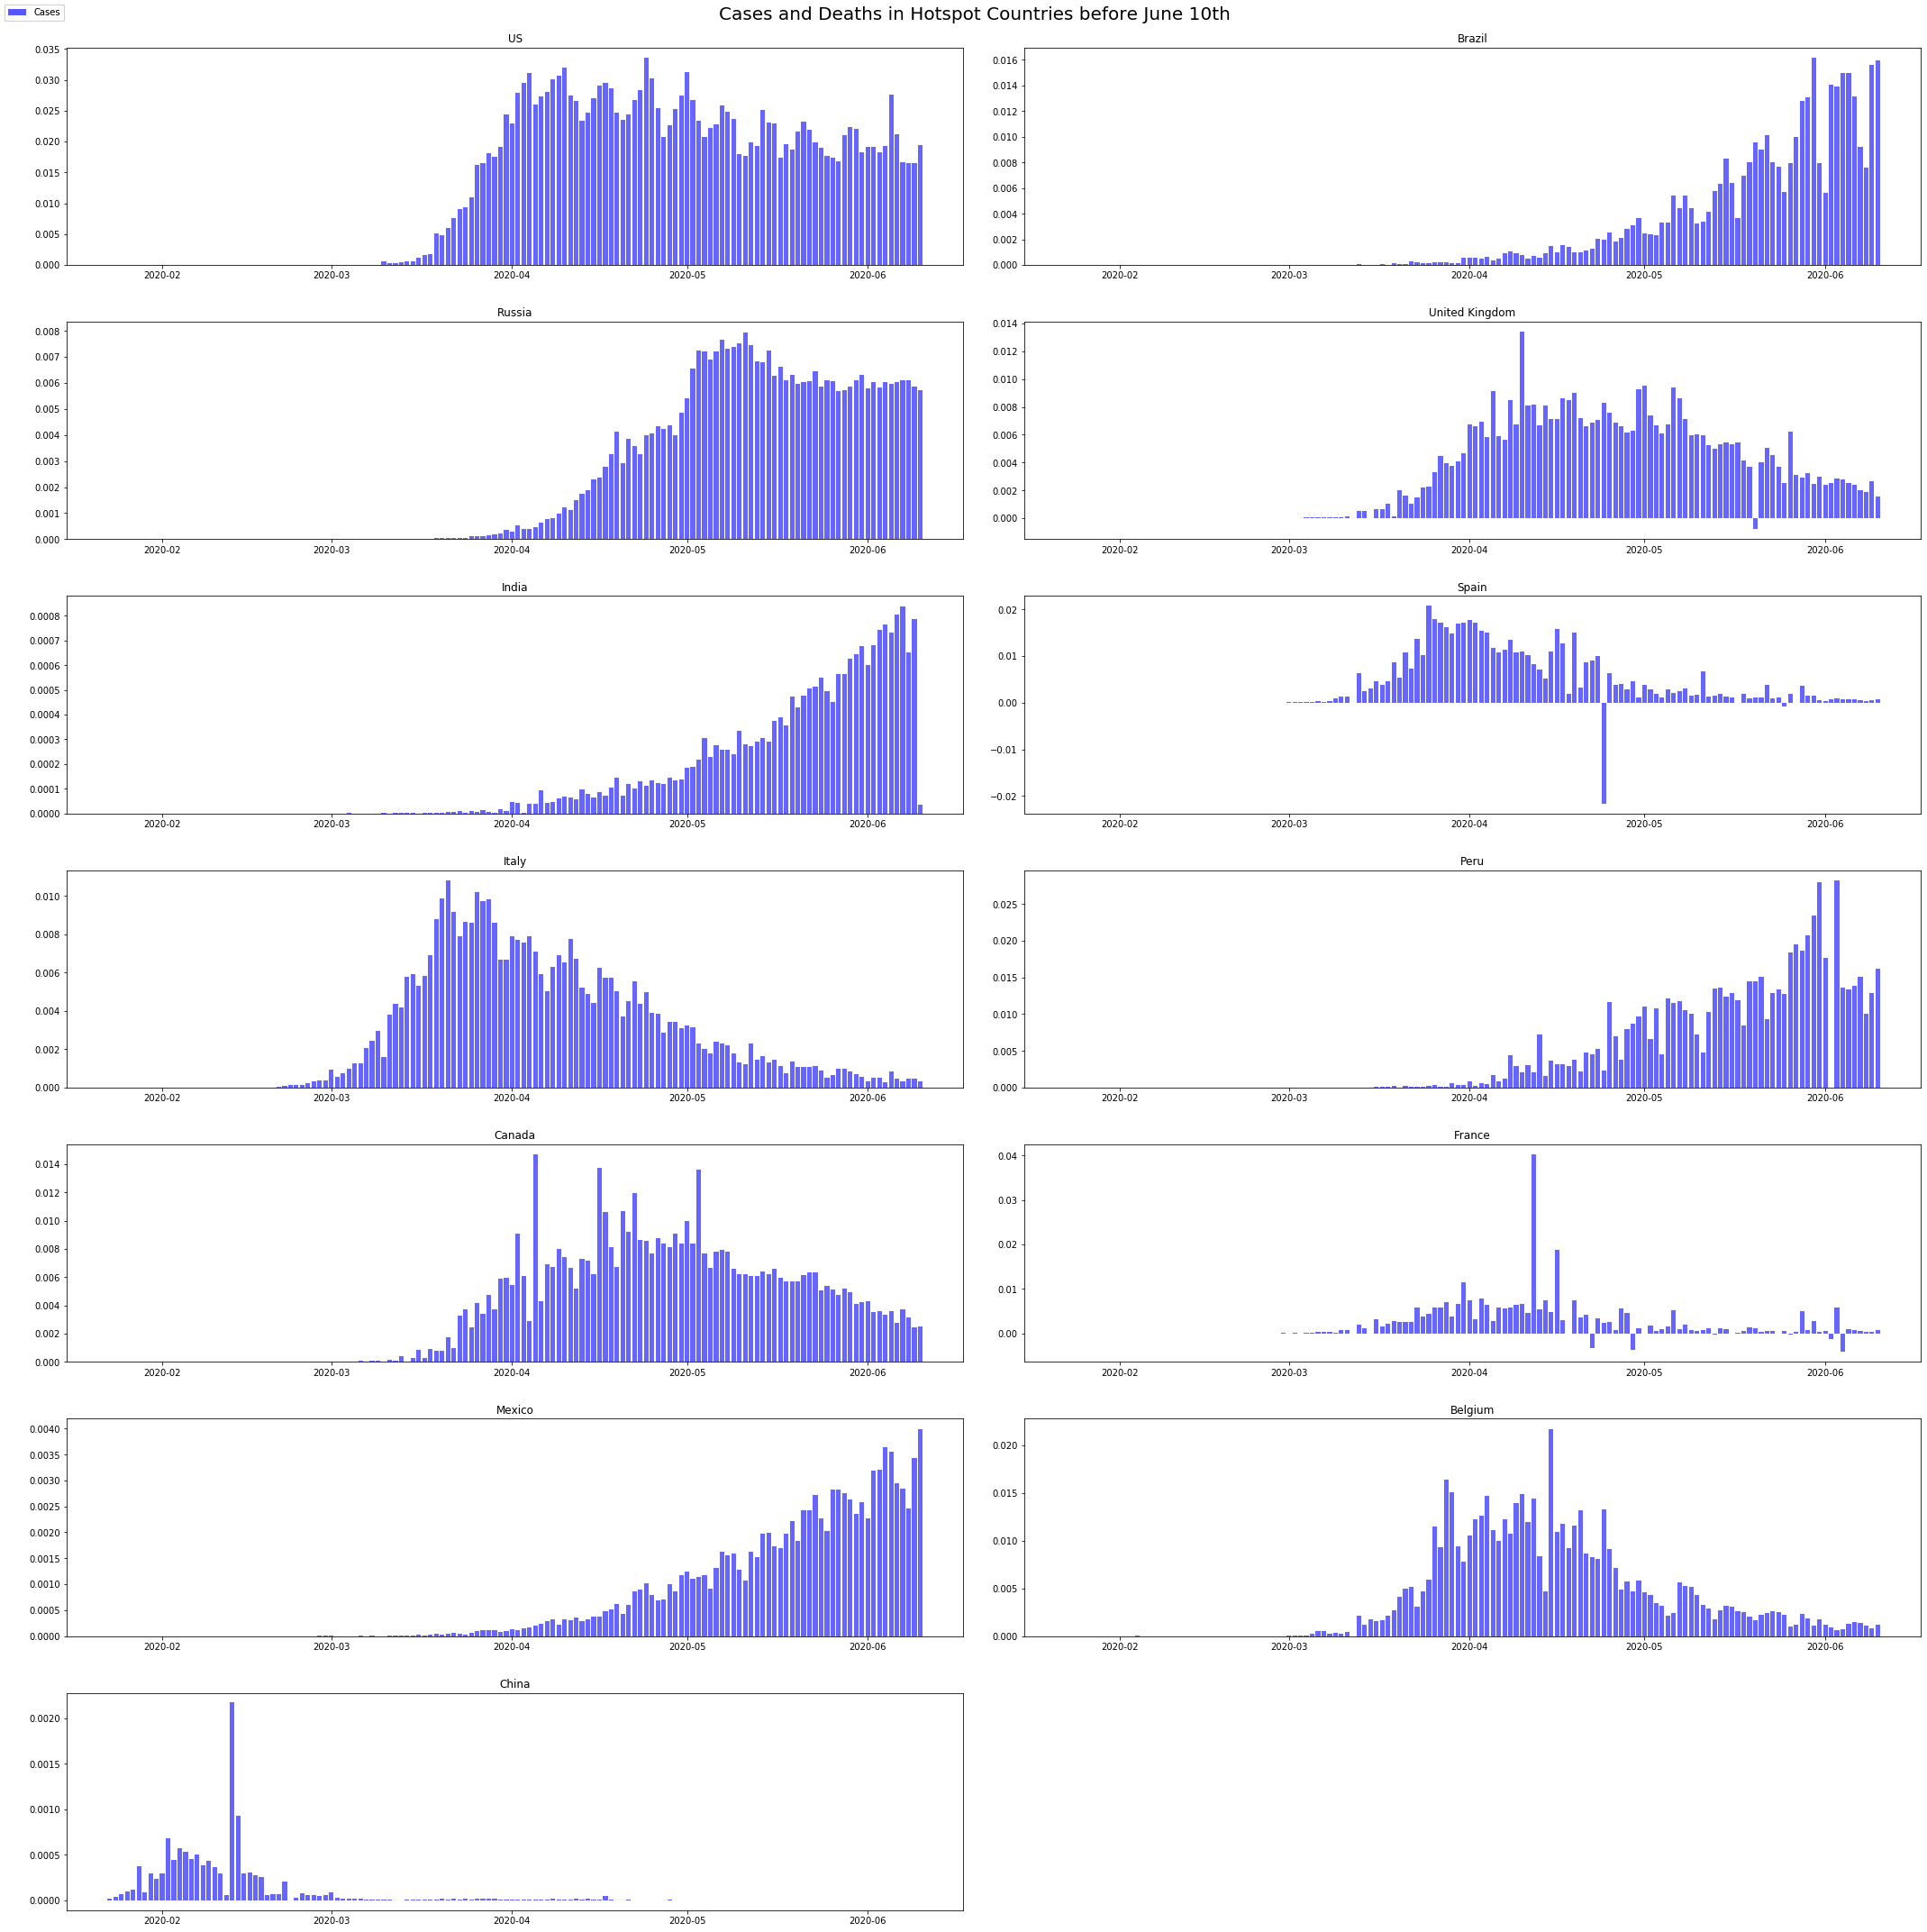

In [188]:
fig = plt.figure(figsize= (30,30))
plt.suptitle('Cases and Deaths in Hotspot Countries before June 10th',fontsize = 20,y=1.0)
for i in range(13):
    ax = fig.add_subplot(7,2,i+1)
    ax.bar(pct_df.index,pct_df.iloc[:,i],color = 'blue',alpha = 0.6, label = 'Percentage');
    plt.title(hotspots[i])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
plt.tight_layout(pad=3.0)

------

## Cases and Deaths within the U.S.
------

Let's focus on some state-level exploratory data analysis in the US data for now.

In [94]:
cases_us = data[(data['Target'] == 'ConfirmedCases') & (data['Country_Region'] == 'US')]
fatal_us = data[(data['Target'] == 'Fatalities') & (data['Country_Region'] == 'US')]
cases_us.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
Date,,,,,,,,,
2020-01-23,67761,Autauga,Alabama,US,55869,0.091485,2020-01-23,ConfirmedCases,0
2020-01-24,67763,Autauga,Alabama,US,55869,0.091485,2020-01-24,ConfirmedCases,0
2020-01-25,67765,Autauga,Alabama,US,55869,0.091485,2020-01-25,ConfirmedCases,0
2020-01-26,67767,Autauga,Alabama,US,55869,0.091485,2020-01-26,ConfirmedCases,0
2020-01-27,67769,Autauga,Alabama,US,55869,0.091485,2020-01-27,ConfirmedCases,0


In [98]:
print('The number of states recorded:',cases_us['Province_State'].nunique())
print('-----------------')
print(cases_us.isnull().sum())
# There are 140 records that are missing the state name. Before figuring out why they are missing, we will drop those rows for now.
cases_us = cases_us[~cases_us['Province_State'].isnull()]
fatal_us = fatal_us[~fatal_us['Province_State'].isnull()]
print('-----------------')
print('After dropping missing records:')
print(cases_us.isnull().sum())

The number of states recorded: 54
-----------------
Id                   0
County            7560
Province_State       0
Country_Region       0
Population           0
Weight               0
Date                 0
Target               0
TargetValue          0
dtype: int64
-----------------
After dropping missing records:
Id                   0
County            7560
Province_State       0
Country_Region       0
Population           0
Weight               0
Date                 0
Target               0
TargetValue          0
dtype: int64


In [101]:
cases_top10_state = find_top_n(cases_us,'Province_State',10)
death_top10_state = find_top_n(fatal_us,'Province_State',10)
print('Top 10 states in the US that have most cases: ', cases_top10_state)
print('Top 10 states in the US that have most deaths: ', death_top10_state)

Top 10 states in the US that have most cases:  ['New York', 'New Jersey', 'California', 'Illinois', 'Massachusetts', 'Pennsylvania', 'Texas', 'Florida', 'Michigan', 'Maryland']
Top 10 states in the US that have most deaths:  ['New York', 'New Jersey', 'Massachusetts', 'Illinois', 'Pennsylvania', 'Michigan', 'California', 'Connecticut', 'Louisiana', 'Maryland']


In [99]:
# Pivot to plot out 50 states
cases_us_pivoted = cases_us[['Province_State','TargetValue']].reset_index().pivot_table(index = 'Date', columns ='Province_State', values = 'TargetValue', aggfunc=np.sum).fillna(0)
death_us_pivoted = fatal_us[['Province_State','TargetValue']].reset_index().pivot_table(index = 'Date', columns ='Province_State', values = 'TargetValue', aggfunc=np.sum).fillna(0)
cases_us_pivoted.shape


(140, 54)

In [102]:
cases_us_pivoted = cases_us_pivoted[cases_top10_state]
death_us_pivoted = death_us_pivoted[death_top10_state]

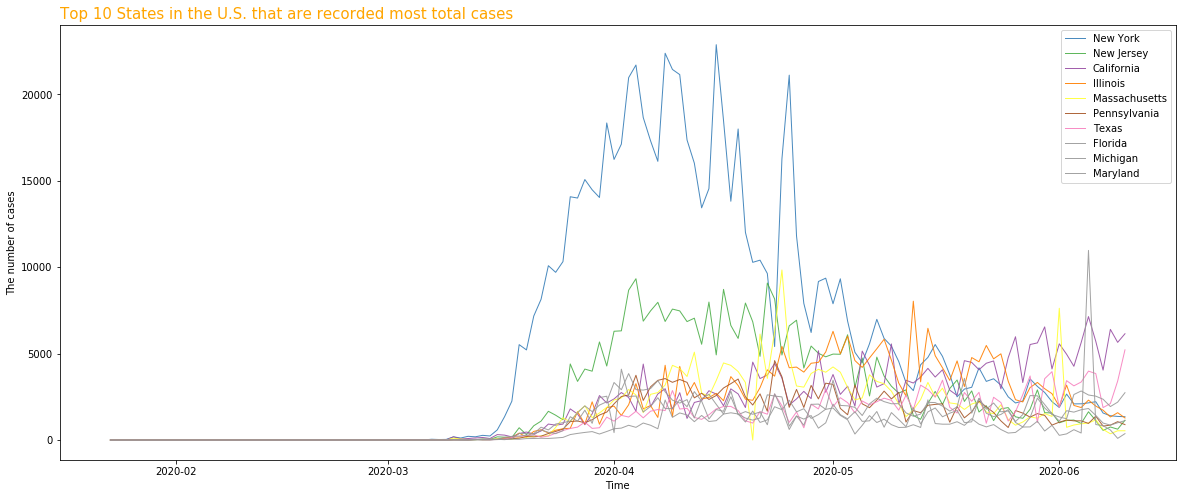

In [125]:
def top_n_states_tsplot(df, about):
    plt.figure(figsize = [20,8])
    # create a color palette
    palette = plt.get_cmap('Set1')
    # multiple line plot
    num=0
    for column in df.columns:
        num+=1
        plt.plot(df.index, df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
    plt.title("Top 10 States in the U.S. that are recorded most total {}".format(about), loc='left', fontsize=15, fontweight=0, color='orange')
    plt.xlabel("Time")
    plt.ylabel("The number of {}".format(about))
    plt.legend()

    
top_n_states_tsplot(cases_us_pivoted, 'cases')

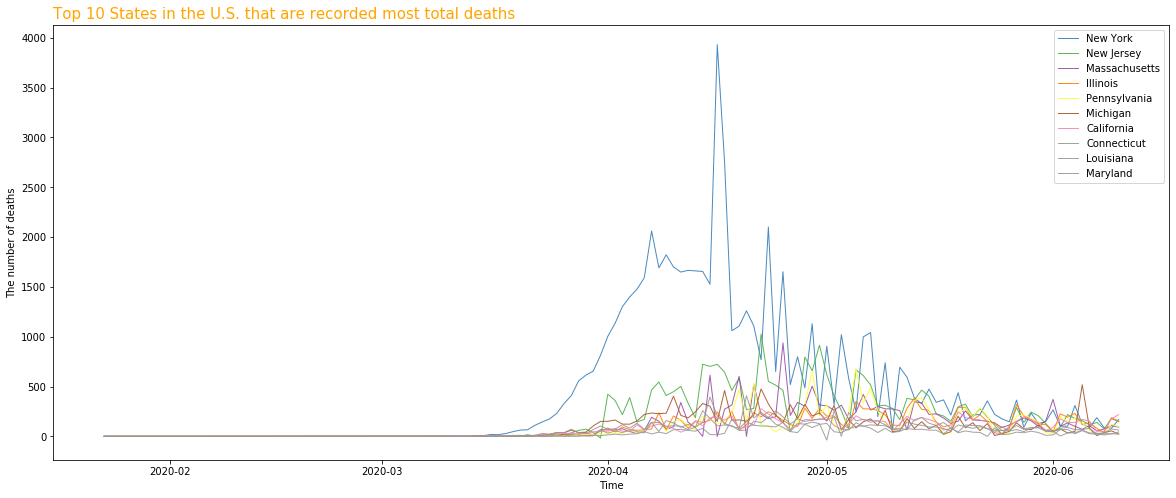

In [126]:
top_n_states_tsplot(death_us_pivoted, 'deaths')